This code is based on the optimized structure of a homo-coupled 6-6 (akg) reaction in MenD (5EJ5) The idea is to keep the ThDP-bound product structure and use this code to only replace the R groups. 

In [2]:
import MDAnalysis as mda
from MDAnalysis.core.universe import Merge
import numpy as np
import os
from utils import *
import warnings 
import matplotlib.pyplot as plt

# Suppress warnings specific to MDAnalysis
warnings.filterwarnings("ignore", category=UserWarning, module="MDAnalysis")

c:\Users\gbonn\anaconda3\envs\md-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# calculate vectors for the direction of each R group
# P denotes prime, the atom of the acceptor molecule 
C2_coords = np.array([-35.281,-36.298,21.222])
C2P_coords = np.array([-35.221,-37.893,21.065])
R_coords = np.array([-36.642,-35.850,20.640])
RP_coords = np.array([-36.528,-38.655,21.359])

C2_R_vec = R_coords - C2_coords
C2P_RP_vec = RP_coords - C2P_coords
C2R_unit = C2_R_vec / np.linalg.norm(C2_R_vec)
C2RP_unit = C2P_RP_vec / np.linalg.norm(C2P_RP_vec)

In [4]:
# define the coordinates of the heavy atom R groups for the donor and acceptor from the optimized geometry
# We will find the average plane through these points and try to match the normal of that plane when we replace 
# the new R groups for donor and acceptor

donor_heavy_atom_R_coords = np.array([[-35.281, -36.298, 21.222],
                                      [-36.642, -35.850, 20.640],
                                      [-36.649, -34.402, 20.172],
                                      [-38.045, -34.224, 19.630],
                                      [-38.831, -33.511, 20.301],
                                      [-38.401, -34.829, 18.588]])

acc_heavy_atom_R_coords =   np.array([[-35.221, -37.893, 21.065],
                                      [-36.528, -38.655, 21.359],
                                      [-36.652, -40.020, 20.681],
                                      [-38.123, -40.440, 20.288],
                                      [-39.005, -39.560, 20.254],
                                      [-38.263, -41.647, 20.032]])

# Calculate the average plane of our template R groups 
donor_normal, donor_centroid = calculate_average_plane(donor_heavy_atom_R_coords)
acc_normal, acc_centroid = calculate_average_plane(acc_heavy_atom_R_coords)

In [5]:
# Calculate the average plane of our template R groups 
donor_normal, donor_centroid = calculate_average_plane(donor_heavy_atom_R_coords)
acc_normal, acc_centroid = calculate_average_plane(acc_heavy_atom_R_coords)


In [6]:
# load receptor universe and extract the different parts of the protein int1 receptor 
head_dir = '5EJ5/int3/'
receptor = mda.Universe(head_dir+'template_modified.pdb')

output_dir = '/Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/Generate_QMMM_Geometries/5EJ5/int3/'

# output the ThDP cofactor
inp_base = receptor.select_atoms("resname INP")
#write_universe(output_dir +'receptor/','INP.pdb',ThDP)

# output just the protein and edit the file so it is Amber readable 
protein = receptor.select_atoms(f"protein or resname MG")
write_universe(output_dir  + 'receptor/','protein.pdb',protein)
edit_protein_files(output_dir + 'receptor/','protein.pdb')

# output the water
try:
    water = receptor.select_atoms(f"resname WAT")
    write_universe(output_dir + 'receptor/','water.pdb',water)
except:
    print('No water to write')

# output the receptor (everything besides ThDP)
protein_MG_water = receptor.select_atoms("not resname INP")
write_universe(output_dir  + 'receptor/','receptor.pdb',protein_MG_water)
edit_protein_files(output_dir  + 'receptor/','receptor.pdb')

File 'protein.pdb' has been written in '/Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/Generate_QMMM_Geometries/5EJ5/int3/receptor/'.
Edited  /Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/Generate_QMMM_Geometries/5EJ5/int3/receptor/protein.pdb  for Amber
File 'water.pdb' has been written in '/Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/Generate_QMMM_Geometries/5EJ5/int3/receptor/'.
File 'receptor.pdb' has been written in '/Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/Generate_QMMM_Geometries/5EJ5/int3/receptor/'.
Edited  /Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/Generate_QMMM_Geometries/5EJ5/int3/receptor/receptor.pdb  for Amber


In [20]:
def diff_btwn_planes(normal_1,normal_2):
    # Normalize the normals
    n1 = normal_1 / np.linalg.norm(normal_1)
    n2 = normal_2 / np.linalg.norm(normal_2)
    
    # Calculate angle between normals
    dot_product = np.dot(n1, n2)
    angle = np.arccos(np.clip(dot_product, -1.0, 1.0))
    
    return angle

def rotation_objective(angle,md_universe,fixed_index_1,fixed_index_2,rotating_atom_indexes,reference_plane_normal,reference_plane_centroid):
    rotated_donor = rotate_atoms(md_universe, fixed_index_1,fixed_index_2,rotating_atom_indexes,angle)
    atom_positions = []
    for i in range(0,len(rotated_donor.atoms)):
        if rotated_donor.atoms[i].type != 'H':
            atom_positions.append(rotated_donor.atoms[i].position)
    plane_normal, plane_centroid = calculate_average_plane(np.array(atom_positions))
    angle_between_planes = diff_btwn_planes(plane_normal,reference_plane_normal)
    dist_between_centroid = get_dist(plane_centroid,reference_plane_centroid)
    return angle_between_planes+dist_between_centroid

def optimize_rotation(initial_angle,md_universe:mda.core.universe.Universe,fixed_index_1:int,fixed_index_2:int,rotating_atom_indexes:list,reference_plane_normal:np.ndarray,reference_plane_centroid:np.ndarray):
    # Set up optimization
    tolerance = 1e-12
    result = minimize(
        rotation_objective,
        initial_angle,
        args=(md_universe.copy(),fixed_index_1,fixed_index_2,rotating_atom_indexes,reference_plane_normal,reference_plane_centroid),
        tol=tolerance,
        method='Nelder-Mead'
    )
    # Check for successful optimization
    if result.success:
        print('ROTATION CONVERGED')
    else:
        print('ROTATION NOT CONVERGED')
    rotated_structure = rotate_atoms(md_universe.copy(), fixed_index_1,fixed_index_2,rotating_atom_indexes, result.x[0])
    #rotated_structure = rotate_atoms(md_universe.copy(), fixed_index_1,fixed_index_2,rotating_atom_indexes, 270)

    return rotated_structure

def find_atom_in_new_universe(md_universe,check_coords):
    min_dist = 10**6 
    for i in range(0,len(md_universe.atoms)):
        curr_pos = md_universe.atoms[i].position
        curr_dist = get_dist(curr_pos,check_coords)
        if curr_dist < min_dist:
            min_dist = curr_dist
            new_atom_index = i
    return new_atom_index

def double_rotation_objective(angles,md_universe,fixed_indexes_1,fixed_indexes_2,rotating_atom_indexes_1,rotating_atom_indexes_2):
    rotated_donor = rotate_atoms(md_universe.copy(), fixed_indexes_1[0],fixed_indexes_1[1],rotating_atom_indexes_1,angles[0])
    rotated_acc = rotate_atoms(rotated_donor.copy(), fixed_indexes_2[0],fixed_indexes_2[1],rotating_atom_indexes_2,angles[1])
    check_atoms = rotating_atom_indexes_1 + rotating_atom_indexes_2
    num_clash = get_atom_clashes(rotated_acc,check_atoms,threshold=1.5)
    return num_clash

def align_and_update_positions(initial_coords,final_coords,md_universe):
    R, t = kabsch_algorithm(initial_coords,final_coords)
    # make a copy of the substrate object and update atom positions by aligning aka head atoms
    universe_aligned = md_universe.copy()
    for i in range(0,len(universe_aligned.atoms.positions)):
        atom_coords = universe_aligned.atoms[i].position
        new_coords = np.dot(R, atom_coords) + t
        universe_aligned.atoms[i].position = new_coords

    return universe_aligned

def optimize_double_rotation(initial_angles,md_universe,fixed_indexes_1,fixed_indexes_2,rotating_atom_indexes_1,rotating_atom_indexes_2):
    # Set up optimization
    tolerance = 1e-6
    result = minimize(
        double_rotation_objective,
        initial_angles,
        args=(md_universe,fixed_indexes_1,fixed_indexes_2,rotating_atom_indexes_1,rotating_atom_indexes_2),
        tol=tolerance,
        method='Nelder-Mead'
    )
    # Check for successful optimization
    if result.success:
        print('ROTATION CONVERGED')
    else:
        print('ROTATION NOT CONVERGED')
    #rotated_structure = rotate_atoms(md_universe.copy(), fixed_index_1,fixed_index_2,rotating_atom_indexes, result.x[0])
    #rotated_structure = rotate_atoms(md_universe.copy(), fixed_index_1,fixed_index_2,rotating_atom_indexes, 270)

    return result.x

In [18]:
# read in each of the substrate files
directory = 'substrates_initial/'
file_names = [f for f in os.listdir(directory)]
file_names = ['6.pdb']

for curr_file_name in file_names:
    print(curr_file_name)
    # load substrate universe
    file_start = curr_file_name.split('.')[0]
    substrate = mda.Universe(directory+curr_file_name)
    # identify the atoms that comprise the aka substrates 
    substrate_important_indexes = get_substrate_aka_indexes(substrate.atoms)
        
    indices_to_remove = [substrate_important_indexes['O1'],
                         substrate_important_indexes['C3'],
                         substrate_important_indexes['O2'],
                         substrate_important_indexes['O3']]
    # S denotes unbound susbtrate we are trying to align 
    C2S_coords = get_atom_position(substrate,substrate_important_indexes['C2'])
    RS_coords = get_atom_position(substrate,substrate_important_indexes['R'])
    initial_S_positions = np.array([C2S_coords,RS_coords])
    if file_start == '7':
        R_dist = bond_dists['C-N']
    else:
        R_dist = bond_dists['C-C']

    guess_R_coords = C2_coords + C2R_unit * R_dist 
    final_donor_positions = np.array([C2_coords,guess_R_coords])
    guess_RP_coords = C2P_coords + C2RP_unit * R_dist 
    final_acc_positions = np.array([C2P_coords,guess_RP_coords])

    donor_aligned = align_and_update_positions(initial_S_positions,final_donor_positions,substrate)
    # Select atoms to keep (all atoms excluding the ones in indices_to_remove)
    mask = ~np.isin(donor_aligned.atoms.indices, indices_to_remove)
    atoms_to_keep = donor_aligned.atoms[mask]
    modified_donor = Merge(atoms_to_keep)
    #write_universe(output_dir+file_start+'/', 'donor.pdb', modified_donor)
    C2_new_index = find_atom_in_new_universe(modified_donor,C2_coords)
    R_new_index = find_atom_in_new_universe(modified_donor,R_coords)
    donor_atoms_to_rotate = [i for i in range(0,len(modified_donor.atoms)) if i not in [C2_new_index,R_new_index]]
    rotated_donor = optimize_rotation(np.array(0),modified_donor.copy(),C2_new_index, R_new_index, donor_atoms_to_rotate,donor_normal,donor_centroid)

    acc_aligned = align_and_update_positions(initial_S_positions,final_acc_positions,substrate)
    # Select atoms to keep (all atoms excluding the ones in indices_to_remove)
    mask = ~np.isin(acc_aligned.atoms.indices, indices_to_remove)
    atoms_to_keep = acc_aligned.atoms[mask]
    modified_acc = Merge(atoms_to_keep)
    #write_universe(output_dir+file_start+'/', 'acc.pdb', modified_acc)
    C2P_new_index = find_atom_in_new_universe(modified_acc,C2P_coords)
    RP_new_index = find_atom_in_new_universe(modified_acc,RP_coords)
    acc_atoms_to_rotate = [i for i in range(0,len(modified_acc.atoms)) if i not in [C2P_new_index,RP_new_index]]
    rotated_acc = optimize_rotation(np.array(0),modified_acc.copy(),C2P_new_index, RP_new_index, acc_atoms_to_rotate,acc_normal,acc_centroid)
    #write_universe(output_dir+file_start+'/', 'rotated_acc.pdb', rotated_acc)

    inp = mda.Merge(inp_base.atoms,rotated_donor.atoms,rotated_acc.atoms)
    for atom in inp.atoms:
        atom.residue.resid = 1
        atom.residue.resname = "INP"
        atom.record_type = "HETATM"
    write_universe(output_dir+file_start+'/', 'inp.pdb', inp)


    complex = mda.Merge(inp.atoms,protein_MG_water.atoms)
    write_universe(output_dir+file_start+'/', 'initial_complex.pdb', complex)
    inp_donor_atoms_to_rotate = []
    for i in donor_atoms_to_rotate:
        new_index = find_atom_in_new_universe(complex,rotated_donor.atoms[i].position)
        inp_donor_atoms_to_rotate.append(new_index)
    C2_complex_index = find_atom_in_new_universe(complex,rotated_donor.atoms[C2_new_index].position) 
    R_complex_index = find_atom_in_new_universe(complex,rotated_donor.atoms[R_new_index].position) 

    inp_acc_atoms_to_rotate = []
    for i in acc_atoms_to_rotate:
        new_index = find_atom_in_new_universe(complex,rotated_acc.atoms[i].position)
        inp_acc_atoms_to_rotate.append(new_index)
    C2P_complex_index = find_atom_in_new_universe(complex,rotated_acc.atoms[C2P_new_index].position) 
    RP_complex_index = find_atom_in_new_universe(complex,rotated_acc.atoms[RP_new_index].position) 

    #final_angles = optimize_double_rotation([90,0],complex,[C2_complex_index,R_complex_index],[C2P_complex_index,RP_complex_index],inp_donor_atoms_to_rotate,inp_acc_atoms_to_rotate)
    
    angles1 = np.linspace(0, 360, 10)
    angles2 = np.linspace(0, 360, 10)
    obj_vals = np.array([[double_rotation_objective([a1, a2],complex,[C2_complex_index,R_complex_index],[C2P_complex_index,RP_complex_index],inp_donor_atoms_to_rotate,inp_acc_atoms_to_rotate) for a2 in angles2] for a1 in angles1])
    min_indexes = np.unravel_index(np.argmin(obj_vals), obj_vals.shape)
    rotated_donor_complex = rotate_atoms(complex.copy(), C2_complex_index,R_complex_index,inp_donor_atoms_to_rotate,angles1[min_indexes[0]])
    rotated_complex = rotate_atoms(rotated_donor_complex.copy(), C2P_complex_index,RP_complex_index,inp_acc_atoms_to_rotate,angles2[min_indexes[1]])
    write_universe(output_dir+file_start+'/', 'final_complex.pdb', rotated_complex)
    inp_final = rotated_complex.select_atoms("resname INP")
    write_universe(output_dir+file_start+'/', 'inp_final.pdb', inp_final)



6.pdb
ROTATION CONVERGED
ROTATION CONVERGED
File 'inp.pdb' has been written in '/Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/Generate_QMMM_Geometries/5EJ5/int3/6/'.
File 'initial_complex.pdb' has been written in '/Users/gbonn/OneDrive - Northwestern University/Bonnanzio Geoffrey/04 Raw Data/Generate_QMMM_Geometries/5EJ5/int3/6/'.


IndexError: index 2 is out of bounds for axis 0 with size 2

In [21]:
tmp = rotated_donor.atoms[0:2] + rotated_donor.atoms[4:]

    

In [22]:
type(tmp)


MDAnalysis.core.groups.AtomGroup

In [10]:
obj_vals

array([[ 7,  6,  6,  7,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  8,
         8,  8, 10,  9,  8,  7,  7,  7,  8, 10, 10, 10,  9,  7],
       [ 6,  5,  5,  6,  5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  7,
         7,  7,  9,  8,  7,  6,  6,  6,  7,  9,  9,  9,  8,  6],
       [ 5,  4,  4,  5,  4,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,
         6,  6,  8,  7,  6,  5,  5,  5,  6,  8,  8,  8,  7,  5],
       [ 6,  5,  5,  6,  5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  7,
         7,  7,  9,  8,  7,  6,  6,  6,  7,  9,  9,  9,  8,  6],
       [ 7,  6,  6,  7,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  8,
         8,  8, 10,  9,  8,  7,  7,  7,  8, 10, 10, 10,  9,  7],
       [ 6,  5,  5,  6,  5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  7,
         7,  7,  9,  8,  7,  6,  6,  6,  7,  9,  9,  9,  8,  6],
       [ 6,  5,  5,  6,  5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  7,
         7,  7,  9,  8,  7,  6,  6,  6,  7,  9,  9,  9,  8,  6],
       [ 5,  4,  4,  5,  4,  4,  3,  3,  

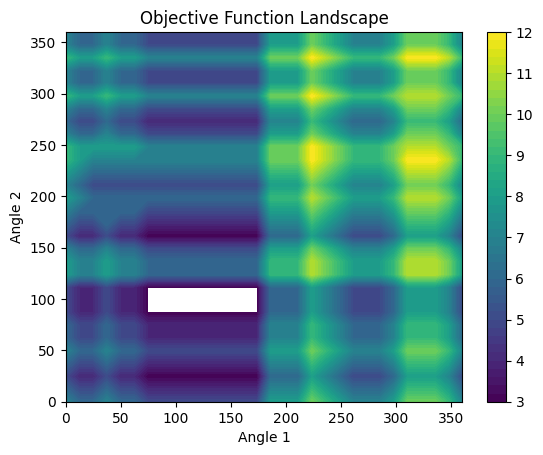

In [11]:
plt.contourf(angles1, angles2, obj_vals, levels=50)
plt.colorbar()
plt.xlabel("Angle 1")
plt.ylabel("Angle 2")
plt.title("Objective Function Landscape")
plt.show()

    

In [12]:
min_index = np.unravel_index(np.argmin(obj_vals), obj_vals.shape)
min_index

(2, 6)

In [13]:
obj_vals[2,6]

3